# VLM for KOMO

In [1]:
import time
import torch
import matplotlib.pyplot as plt

from high_level_funcs import RobotEnviroment
from utils import generate_blocks_scene, cleanup_highlvl_func

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")

Device Name: NVIDIA GeForce RTX 3090


## Prepare your scene

In [4]:
C = generate_blocks_scene()
C.view()

0

## Prepare your VLM

In [5]:
# from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype="auto",
#     device_map=device
# )
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

## Take a picture of the scene

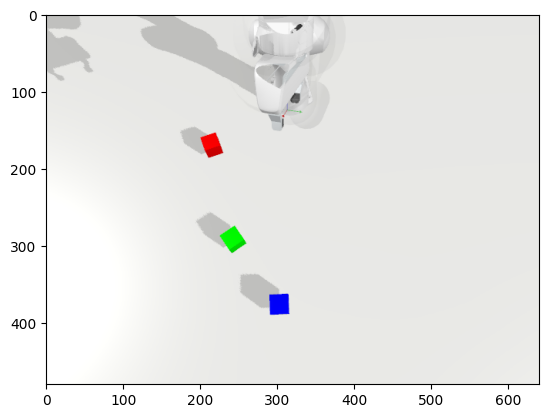

In [6]:
camera_frame = C.getFrame('topCamera')
print(camera_frame)
C.view_setCamera(camera_frame)
C.view()
time.sleep(1.)

rgb = C.view_getRgb()
depth = C.view_getDepth()

img_idx = 0
image_path = "../scene_image0.jpg"
plt.imsave(image_path, rgb)
plt.imshow(rgb)

## Prepare initial prompt

In [7]:
from prompting import prompt_qwen

# task_description = "Stack the blocks on top of each other."
# task_description = "order the blocks with respect to color in rgb"
task_description = "push the red block towards the blue block and then place the green block on the red block"


with open("./prompts/abstract_primitives/abstract_primitives_tutorial.txt", 'r') as file:
    high_tutorial = file.read()

with open("./prompts/abstract_primitives/problem_definition.txt", 'r') as file:
    problem_definition = file.read()

frame_names = [line for line in C.getFrameNames() if not line.startswith("l_")]

global_text = f"{high_tutorial}\n{problem_definition}"
task_specific_text = f"{task_description}\nHere is a list of all available object names: {frame_names}"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": global_text,
            },
            {
                "type": "image",
                "image": image_path,
            },
            {
                "type": "text",
                "text": task_specific_text,
            },
        ],
    },
]
full_text = f"{global_text}\n{task_specific_text}"
print(full_text)

The following text defines abstract primitive functions which are well defined already. You can use them for manipulating the robot arm as you like.

pick(object_name)
- Generates a pick motion of an object
- Parameters:
  - object_name (str): The name of the object to be picked

place(x, y, z)
- Generates a place motion of the robots object in hand, this means that a pick is first necessary
- Parameters: 
  - x (float): The absolute x target position to place the object
  - y (float): The absolute y target position to place the object
  - z (float): The absolute z target position to place the object

push(object_name, x_rel, y_rel)
- Generates a push motion of a specific object into a direction
- Parameters:
  - object_name (str): The name of the object to be pushed
  - x_rel (float): the relative x coordinate of the push
  - y_rel (float): the relative y coordinate of the push

getObj(object_name)
- Returns an object from which the following parameters can be queried: pos.x, pos.y, p

## Main loop

In [ ]:
# out = prompt_qwen(model, processor, device, messages)
out = """def stack_blocks():
    # Get information about each block
    red_block = getObj("block_red")
    green_block = getObj("block_green")
    blue_block = getObj("block_blue")
    
    # Order the blocks by their positions to ensure stacking starts from the table
    blocks = sorted([red_block, green_block, blue_block], key=lambda block: block.pos.z)
    
    # Start stacking
    for i in range(len(blocks)):
        block = blocks[i]
        
        # Pick the current block
        pick(block.name)
        
        # Compute placement coordinates
        if i == 0:
            # First block goes directly to the table's position
            place_x, place_y, place_z = block.pos.x, block.pos.y, block.pos.z
        else:
            # Subsequent blocks are stacked on top of the previous block
            previous_block = blocks[i - 1]
            place_x = previous_block.pos.x
            place_y = previous_block.pos.y
            place_z = previous_block.pos.z + previous_block.size.z
        
        # Place the block
        place(place_x, place_y, place_z)
"""

# out = """def sort_blocks_by_color():
#     # Define block names in RGB order
#     block_names = ['block_red', 'block_green', 'block_blue']

#     # Get the initial position of the first block as the reference position
#     first_block = getObj(block_names[0])
#     base_x = first_block.pos.x
#     base_y = first_block.pos.y
#     base_z = first_block.pos.z

#     # Calculate the placement offset based on block size
#     block_size_x = first_block.size.x
#     placement_offset = block_size_x * 1.5  # Add some spacing between blocks

#     for i, block_name in enumerate(block_names):
#         # Get the block object to retrieve its parameters
#         block = getObj(block_name)

#         # Step 1: Pick the block
#         pick(block_name)

#         # Step 2: Place the block at its target position
#         # Compute target x position relative to base position
#         target_x = base_x + i * placement_offset
#         target_y = base_y  # Align with the same y-axis as the base
#         target_z = base_z  # Align with the table height (z-axis of base)

#         place(target_x, target_y, target_z)
# """

# out = """def solve_robot_task():
#     # Get object information
#     red_block = getObj('block_red')
#     green_block = getObj('block_green')
#     blue_block = getObj('block_blue')

#     # Push the red block towards the blue block
#     # Calculate the relative x and y direction for the push, assuming we want to align the red block's center with the blue block's center
#     x_rel_push = blue_block.pos.x - red_block.pos.x
#     y_rel_push = blue_block.pos.y - red_block.pos.y
#     push('block_red', x_rel_push, y_rel_push)

#     # Pick the green block
#     pick('block_green')

#     # Place the green block on top of the red block
#     # The placement position should align with the red block's position in x and y,
#     # and the z position should account for the height of the red block.
#     place_x = red_block.pos.x
#     place_y = red_block.pos.y
#     place_z = red_block.pos.z + red_block.size.z

#     place(place_x, place_y, place_z)
# """

out = cleanup_highlvl_func(out, compute_collisions=False)
print(out)

exec(out)

def solve_robot_task():
    env = RobotEnviroment(C, visuals=True, verbose=1, compute_collisions=False)
    # Get object information
    red_block = env.getObj('block_red')
    green_block = env.getObj('block_green')
    blue_block = env.getObj('block_blue')

    # Push the red block towards the blue block
    # Calculate the relative x and y direction for the push, assuming we want to align the red block's center with the blue block's center
    x_rel_push = blue_block.pos.x - red_block.pos.x
    y_rel_push = blue_block.pos.y - red_block.pos.y
    env.push('block_red', x_rel_push, y_rel_push)

    # Pick the green block
    env.pick('block_green')

    # Place the green block on top of the red block
    # The placement position should align with the red block's position in x and y,
    # and the z position should account for the height of the red block.
    place_x = red_block.pos.x
    place_y = red_block.pos.y
    place_z = red_block.pos.z + red_block.size.z

    env.place(place_x, 